<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-CNN-Projects/blob/master/Persian-Digits-Dataset-CNN/03_persian_digits_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import io
import cv2

# Load Dataset

In [3]:
from google.colab import userdata
import os

os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

!kaggle datasets download amirmahdiabbootalebi/persian-handwritten-digits
!ls
!unzip persian-handwritten-digits.zip

Streaming output truncated to the last 5000 lines.
  inflating: Train/class_9/image_5499.jpg  
  inflating: Train/class_9/image_55.jpg  
  inflating: Train/class_9/image_550.jpg  
  inflating: Train/class_9/image_5500.jpg  
  inflating: Train/class_9/image_5501.jpg  
  inflating: Train/class_9/image_5502.jpg  
  inflating: Train/class_9/image_5503.jpg  
  inflating: Train/class_9/image_5504.jpg  
  inflating: Train/class_9/image_5505.jpg  
  inflating: Train/class_9/image_5506.jpg  
  inflating: Train/class_9/image_5507.jpg  
  inflating: Train/class_9/image_5508.jpg  
  inflating: Train/class_9/image_5509.jpg  
  inflating: Train/class_9/image_551.jpg  
  inflating: Train/class_9/image_5510.jpg  
  inflating: Train/class_9/image_5511.jpg  
  inflating: Train/class_9/image_5512.jpg  
  inflating: Train/class_9/image_5513.jpg  
  inflating: Train/class_9/image_5514.jpg  
  inflating: Train/class_9/image_5515.jpg  
  inflating: Train/class_9/image_5516.jpg  
  inflating: Train/class_9/im

# Load Data for TensorFlow

In [4]:
import tensorflow as tf

# Define the directories for training and testing data
train_dir = 'Train'
test_dir = 'Test'

# Set image size and batch size
img_height = 64  # You can adjust this based on your images
img_width = 64   # You can adjust this based on your images
batch_size = 32

# Load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  labels='inferred',
  label_mode='int',
  image_size=(img_height, img_width),
  interpolation='nearest',
  batch_size=batch_size)

# Load the testing dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  labels='inferred',
  label_mode='int',
  image_size=(img_height, img_width),
  interpolation='nearest',
  batch_size=batch_size,
  shuffle=False) # No need to shuffle test data

# Print the number of batches in each dataset
print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Number of testing batches: {tf.data.experimental.cardinality(test_ds).numpy()}")

Found 100000 files belonging to 10 classes.
Found 50000 files belonging to 10 classes.
Number of training batches: 3125
Number of testing batches: 1563


**Explanation:**

*   We import the `tensorflow` library.
*   We define the paths to the training and testing directories.
*   We set the desired image height, width, and batch size.
*   We use `tf.keras.utils.image_dataset_from_directory` to load the datasets.
    *   `labels='inferred'` automatically infers labels from subdirectory names.
    *   `label_mode='int'` encodes labels as integers.
    *   `image_size` resizes the images to the specified dimensions.
    *   `interpolation='nearest'` is used for resizing.
    *   `batch_size` sets the number of images per batch.
*   We print the number of batches in each dataset to verify the loading.

# Check Image Per Class

Class names: ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']


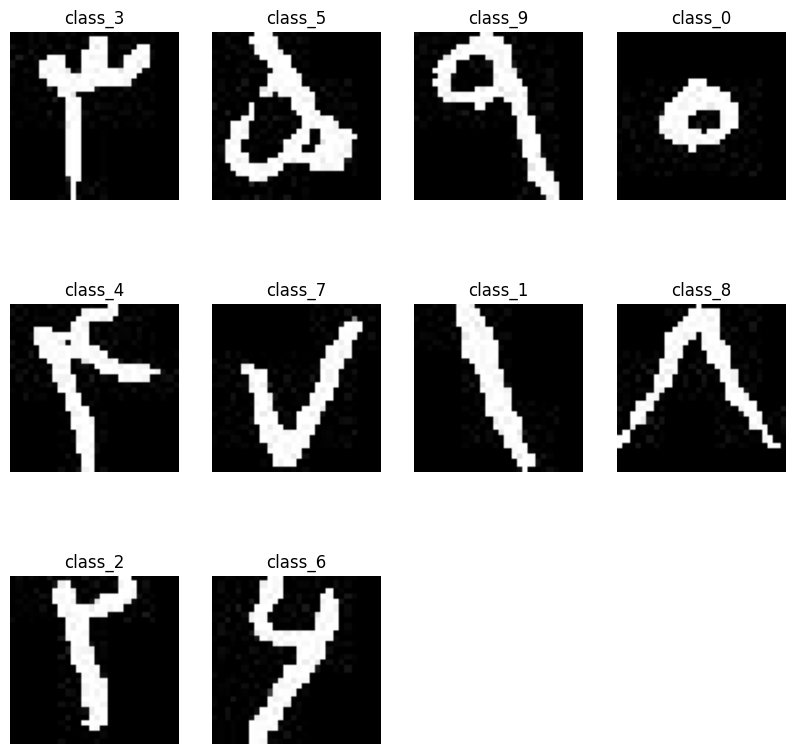

In [5]:
# Get class names
class_names = train_ds.class_names
print(f"Class names: {class_names}")

# Dictionary to store one image per class
images_per_class = {}

# Iterate through the dataset to collect one image per class
for images, labels in train_ds:
    for i in range(len(labels)):
        label = class_names[labels[i]]
        if label not in images_per_class:
            images_per_class[label] = images[i].numpy().astype("uint8")
        if len(images_per_class) == len(class_names):
            break
    if len(images_per_class) == len(class_names):
        break

# Plot one image per class
plt.figure(figsize=(10, 10))
for i, (label, image) in enumerate(images_per_class.items()):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")
plt.show()

# Normalize Data

In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

**Explanation:**

*   We create a `Rescaling` layer from `tf.keras.layers` to normalize the pixel values by dividing by 255.
*   We use the `map` function to apply this normalization layer to both the training and testing datasets. This creates new datasets (`normalized_train_ds` and `normalized_test_ds`) with normalized images.

# Cache and Prefetch Data

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

cached_train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
cached_test_ds = normalized_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Explanation:**

*   `AUTOTUNE` allows the TensorFlow runtime to dynamically tune the `buffer_size` for prefetching based on the available CPU.
*   `.cache()` caches the dataset elements in memory after the first epoch, avoiding redundant loading and preprocessing.
*   `.prefetch(buffer_size=AUTOTUNE)` overlaps the data preprocessing and model execution, ensuring that data is ready when the model needs it.

# Check Dataset Shape

In [8]:
# Get a batch from the cached training dataset
for image_batch, label_batch in cached_train_ds.take(1):
  print("Cached training dataset batch shape:")
  print(image_batch.shape)
  print(label_batch.shape)

# Get a batch from the cached testing dataset
for image_batch, label_batch in cached_test_ds.take(1):
  print("Cached testing dataset batch shape:")
  print(image_batch.shape)
  print(label_batch.shape)

Cached training dataset batch shape:
(32, 64, 64, 3)
(32,)
Cached testing dataset batch shape:
(32, 64, 64, 3)
(32,)


# Define the Model

In [9]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input # Import Input layer

num_classes = len(class_names)

model = Sequential([
  Input(shape=(img_height, img_width, 3)), # Use Input layer
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Explanation:**

*   We import the necessary layers and the `Sequential` model from `tensorflow.keras`.
*   We define the number of classes based on the `class_names` obtained earlier.
*   We create a `Sequential` model, which is a linear stack of layers.
*   The model includes:
    *   Three `Conv2D` layers with increasing filters (32, 64, 128) and ReLU activation for learning spatial features.
    *   Three `MaxPooling2D` layers to reduce the spatial dimensions and computational complexity.
    *   A `Flatten` layer to convert the 2D feature maps into a 1D vector.
    *   A `Dense` layer with 128 units and ReLU activation for further processing.
    *   A final `Dense` layer with `num_classes` units to output the class predictions.

# Compile and Train the Model

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,490 (2.61 MB)

 Trainable params: 684,490 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

**Explanation:**

*   We compile the model using the `compile` method.
*   **Optimizer:** We use the 'adam' optimizer, which is a popular choice for many deep learning tasks.
*   **Loss Function:** We use `SparseCategoricalCrossentropy` because our labels are integers. `from_logits=True` is set because the model's output layer does not have an activation function (like softmax).
*   **Metrics:** We track 'accuracy' to evaluate the model's performance.
*   `model.summary()` prints a summary of the model's layers and parameters.

# Define Callbacks

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

# Define Model Checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.keras', save_best_only=True, monitor='val_loss')

callbacks = [early_stopping, model_checkpoint]

**Explanation:**

*   We import `EarlyStopping` and `ModelCheckpoint` from `tensorflow.keras.callbacks`.
*   **Early Stopping:** This callback monitors the validation loss (`val_loss`) and stops training if it doesn't improve for a specified number of epochs (`patience=5`). `restore_best_weights=True` ensures that the model's weights are restored to the epoch with the best validation loss.
*   **Model Checkpoint:** This callback saves the model's weights to a file (`'best_model.keras'`) during training. `save_best_only=True` ensures that only the model with the best validation loss is saved.
*   We create a list `callbacks` containing the defined callbacks to be used during training.

# Train the Model

In [12]:
epochs = 10 # You can adjust the number of epochs

history = model.fit(
    cached_train_ds,
    validation_data=cached_test_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.9772 - loss: 0.0733 - val_accuracy: 0.9966 - val_loss: 0.0108
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - accuracy: 0.9965 - loss: 0.0114 - val_accuracy: 0.9976 - val_loss: 0.0086
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.9977 - loss: 0.0068 - val_accuracy: 0.9976 - val_loss: 0.0082
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9982 - loss: 0.0053 - val_accuracy: 0.9974 - val_loss: 0.0092
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.9989 - loss: 0.0037 - val_accuracy: 0.9970 - val_loss: 0.0112
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9987 - loss: 0.0036 - val_accuracy: 0.9984 - val_loss: 0.0081
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9991 - loss: 0.0028 - val_accuracy: 0.9982 - val_loss: 0.0080
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9990 - loss: 

**Explanation:**

*   We define the number of training epochs.
*   We train the model using the `fit` method:
    *   `cached_train_ds`: The cached training dataset.
    *   `validation_data=cached_test_ds`: The cached testing dataset used for validation during training.
    *   `epochs`: The number of epochs to train for.
    *   `callbacks`: The list of callbacks to be applied during training.
*   The training history is stored in the `history` object, which can be used to plot training progress.

# Evaluate Model Performance

In [13]:
loss, accuracy = model.evaluate(cached_test_ds)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9982 - loss: 0.0078
Test Loss: 0.0080
Test Accuracy: 0.9982


**Explanation:**

*   We use the `evaluate` method of the trained model to calculate the loss and metrics on the test dataset (`cached_test_ds`).
*   The `evaluate` method returns the loss value and the values of the metrics specified during compilation (in this case, accuracy).
*   We print the test loss and test accuracy to assess the model's performance on unseen data.

# Make Predictions on New Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
True Label: class_0
Predicted Label: class_0


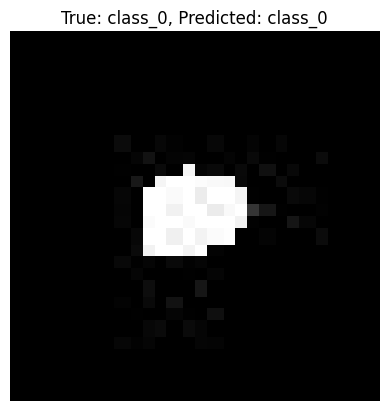

In [14]:
# Get a batch of images and labels from the test set
image_batch, label_batch = next(iter(cached_test_ds))

# Select a single image and its label from the batch
single_image = image_batch[0]
true_label = label_batch[0]

# Expand the dimensions of the single image to match the model's input shape (batch size of 1)
img_array = tf.expand_dims(single_image, 0)

# Make a prediction using the trained model
predictions = model.predict(img_array)

# Get the predicted class (the one with the highest probability)
predicted_class = tf.argmax(predictions[0]).numpy()

# Get the class names
class_names = train_ds.class_names # Assuming class_names is still available

print(f"True Label: {class_names[true_label]}")
print(f"Predicted Label: {class_names[predicted_class]}")

# Display the image
plt.imshow(single_image.numpy())
plt.title(f"True: {class_names[true_label]}, Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()

**Explanation:**

*   We get a batch of images and labels from the `cached_test_ds`.
*   We select the first image and its corresponding true label from the batch.
*   We expand the dimensions of the image using `tf.expand_dims` to create a batch of size 1, which is required for the `model.predict` method.
*   We use `model.predict` to get the model's predictions for the single image. The output is a probability distribution over the classes.
*   `tf.argmax` is used to find the index of the class with the highest predicted probability, which is our predicted class.
*   We get the class name for both the true label and the predicted label using the `class_names` list.
*   Finally, we print the true and predicted labels and display the image with the labels as the title.

# Visualize Training and Validation Loss/Accuracy

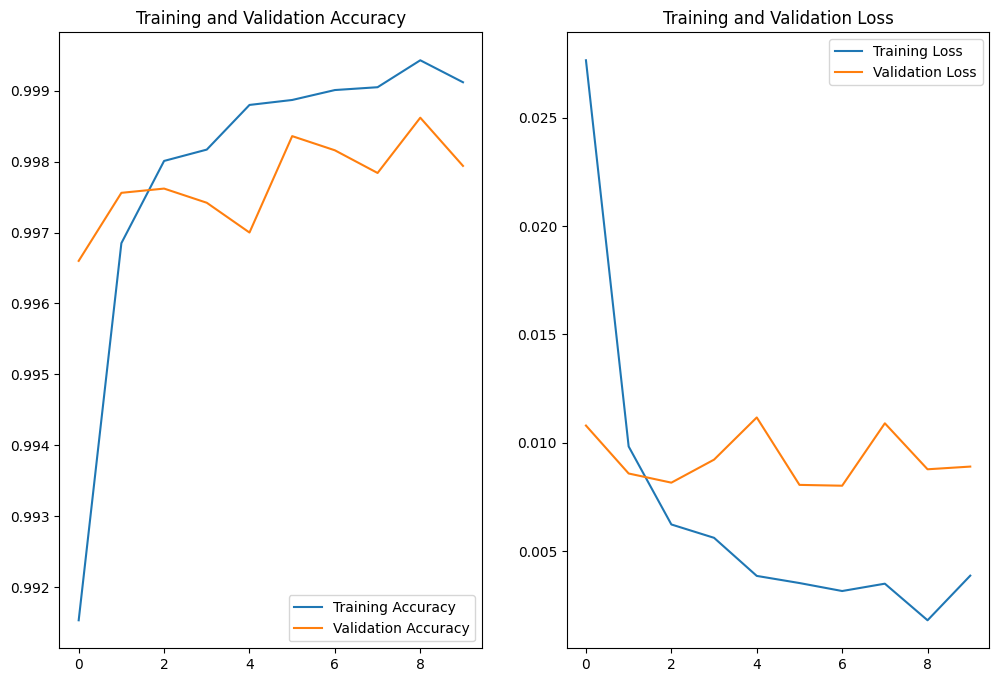

In [15]:
# Get the training and validation metrics from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Explanation:**

*   We access the training and validation accuracy and loss values from the `history` object returned by `model.fit`.
*   We create a range of epochs for the x-axis of the plots.
*   We create a figure with two subplots to display the accuracy and loss separately.
*   In the first subplot, we plot the training and validation accuracy over epochs and add a legend and title.
*   In the second subplot, we plot the training and validation loss over epochs and add a legend and title.
*   Finally, we display the plots to visualize the training progress.